# Assessment for Advanced Data Science

## Christian Cabrera, Radzim Sendyka, Carl Henrik Ek and Neil D. Lawrence

### 6th November 2023



Welcome to the course assessment for the Advanced Data Science unit. In this assessment you will build a prediction system for UK house prices.

Your prediction system will be based on data from the UK Price Paid data available [here](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). By combining this data with the UK Office for National Statistics data on the latitude/longitude of postcodes (available [here](https://www.getthedata.com/open-postcode-geo)) you will have a record of house prices and their approximate latitude/longitude. Due to the size of these data you will use a relational database to handle them.  

To make predictions of the house price you will augment your data with information obtained from Open Street Map: an open license source of mapping information. You will use the techniques you have learnt in the course to indentify and incorporate useful features for house price prediction.



Alongside your implementation you will provide a short repository overview describing how you have implemented the different parts of the project and where you have placed those parts in your code repository. You will submit your code alongside a version of this notebook that will allow your examiner to understand and reconstruct the thinking behind your analysis. This notebook is structured to help you in creating that description and allow you to understand how we will allocate the marks. You should make use of the Fynesse framework (<https://github.com/lawrennd/fynesse_template>) for structuring your code.

Remember the notebook you create should *tell a story*, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template)

The maximum total mark for this assessment is 20. That mark is split into Three Questions below, each worth 5 marks each. Then a final 5 marks will be given for the quality, structure and reusability of the code and analysis you produce giving 20 marks in total. At the end, we would like to know your experience using LLMs in this assignment.

### Important Note:

*Some tasks in this assignment require you to develop skills for searching for multiple solutions and trying different things. This environment recreates industrial data science and software engineering problems. There is no one right answer.*


### Useful Links

You may find some of the following links useful when building your system.

University instuctions on Security and Privacy with AWS.

https://help.uis.cam.ac.uk/service/network-services/hosting-services/AWS/aws-security-privacy

Security Rules in AWS

https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/USER_VPC.Scenarios.html#USER_VPC.Scenario4

### Installing Your Library

One artefact to be included in your submission is a python library structured according to the "Access, Assess, Address" standard for data science solutions. You will submit this library alongside your code. Use the cell below to perform the necessary installation instructions for your library.

You should base your module on the template repository given by the Fynesse template repository. That should make it `pip` installable as below.



In [1]:
# Install your library here, for example the fynesse template
# is set up to be pip installable
# %pip install git+https://github.com/lawrennd/fynesse_template.git
import sys
# TODO: replace with pip installation based on the original repository teplaced with my github repo URL
sys.path.insert(0, "/home/xt0r3-user/cambridge/partii/michaelmas/ads")

Your own library should be installed in the line above, then you can import it as usual (where you can either replace `fynesse` with the name you've given your analysis module or you can leave the name as `fynesse` as you prefer).

## Global Control Variables

In [2]:
FORCE_RELOAD = False
LOCAL_DB = True

## Imports

In [3]:
%load_ext autoreload
%autoreload 2

In [142]:
import fynesse
from utils.plotting_utils import subplots_iter

In [21]:
from pathlib import Path
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from geopandas.tools import sjoin

import yaml
from ipywidgets import Password, Text, interact_manual

## Question 1. Accessing a Database of House Prices, Latitudes and Longitudes

The UK price paid data for housing dates back to 1995 and contains millions of transactions. The size of the data makes it unwieldy to manipulate directly in python frameworks such as `pandas`. As a result we will host the data in a *relational database*.

Using the following ideas.

1. A cloud hosted database (such as MariaDB hosted on the AWS RDS service).
2. The SQL language wrapped in appropriately structured python code.
3. Joining of two databases.

You will construct a database containing tables that contain all house prices, latitudes and longitudes from the UK house price data base since 1995.

You will likely find the following resources helpful.

1. Lecture 1, 2 and 3.
2. Lab class 1 and 2.
3. The UK Price Paid data for houses: <https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads>
4. The UK ONS Data base of postcode latitude and longitudes:  <https://www.getthedata.com/open-postcode-geo>

Below we provide codeboxes and hints to help you develop your answer.

### Important Notes:

*The main knowledge you need to do a first pass through this question will have been taught by the end of Lab Session 2 (31st October 2023). You will likely want to review your answer as part of **refactoring** your code  and analysis pipeline shortly before hand in.*

*We recommend doing Question 1 as early as possible to avoid being blocked from important work given that uploading the data can take long.*

*If you encounter problems with the online notebook (e.g., interrupted connections with the AWS server), you can use a local IDE to work in your machine.*

*5 Marks*

### Licenses

In [6]:
print(fynesse.access.legal())

Contains HM Land Registry data © Crown copyright and database right 2021. 
This data is licensed under the Open Government Licence v3.0.

Contains OS data © Crown copyright and database right 2023
Contains OS data © Crown copyright and database right 2023
Contains Royal Mail data © Royal Mail copyright and database right 2023
Contains OS data © Crown copyright and database right 2023
Contains Royal Mail data © Royal Mail copyright and Database right 2023
Contains GeoPlace data © Local Government Information House Limited copyright and database right 2023
Source: Office for National Statistics licensed under the Open Government Licence v.3.0



### Task A

Set up the database. You'll need to set up a database on AWS. You were guided in how to do this in the lab sessions. You should be able to use the same database instance you created in the lab, or you can delete that and start with a fresh instance. You'll remember from the lab that the database requires credentials (username, password) to access. It's good practice to store those credentials *outside* the notebook so you don't accidentally share them by e.g. checking code into a repository.
  
Call the database you use for this assessment `property_prices`.
  

In [7]:
if not Path("credentials.yaml").exists():

    @interact_manual(
        username=Text(description="Username:"),
        password=Password(description="Password:"),
    )
    def write_credentials(username, password):
        with open("credentials.yaml", "w") as file:
            credentials_dict = {"username": username, "password": password}
            yaml.dump(credentials_dict, file)

In [8]:
with open("credentials.yaml") as file:
    credentials = yaml.safe_load(file)

db = fynesse.access.GlobalDatabaseManager(
    username = credentials['username'],
    password = credentials['password'],
)

loader = fynesse.access.DatasetLoader(db)

In [9]:
loader.create_main_table()

### Task B

Create a database table called `pp_data` containing all the UK Price Paid data from the [gov.uk site](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). You'll need to prepare a new table to receive the data and upload the UK Price Paid data to your database instance. The total data is over 3 gigabytes in size. We suggest that rather than downloading the full data in CSV format, you use the fact that they have split the data into years and into different parts per year. For example, the first part of the data for 2018 is stored at <http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018-part1.csv>. Each of these files is less than 100MB and can be downloaded very quickly to local disk, then uploaded using


```
LOAD DATA LOCAL INFILE 'filename' INTO TABLE `table_name`
FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED by '"'
LINES STARTING BY '' TERMINATED BY '\n';
```
*Note* this command should be wrapped and placed in an appropriately structured python module.

Each 'data part' should be downloadable from the `gov.uk` site. It should take around 5 minutes to download the whole dataset. By looping across the years and different parts, you should be able to robustly upload this large data set to your database instance in around 15 minutes. You should get a table with 28'258,161 rows. ***Note: A select count of the table can take more than half an hour.***

You may find the following schema useful in the creation of your table:

```
--
-- Table structure for table `pp_data`
--
DROP TABLE IF EXISTS `pp_data`;
CREATE TABLE IF NOT EXISTS `pp_data` (
  `transaction_unique_identifier` tinytext COLLATE utf8_bin NOT NULL,
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `primary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `secondary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `street` tinytext COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `ppd_category_type` varchar(2) COLLATE utf8_bin NOT NULL,
  `record_status` varchar(2) COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;
```
This schema is written by Dale Potter and can be found on Github here: <https://github.com/dalepotter/uk_property_price_data/blob/master/create_db.sql>

You may also find it helpful to set up the following primary key to the `pp_data` table. This should be done before uploading your data.

```
--
-- Primary key for table `pp_data`
--
ALTER TABLE `pp_data`
ADD PRIMARY KEY (`db_id`);

ALTER TABLE `pp_data`
MODIFY db_id bigint(20) unsigned NOT NULL AUTO_INCREMENT, AUTO_INCREMENT=1;
```

In the box below, briefly describe what the schema is doing.

```GIVE YOUR WRITTEN ANSWER HERE```


TODO: refine this  

It gives the types of different columns of the database.  
E.g. `varchar(8) COLLATE utf8_bin NOT NULL,` means an `utf_8` encoded character sequence of length at most 8 without missing values.

In [10]:
loader.process_prices()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


### Task C

Create a database table called `postcode_data` containing the ONS Postcode information. <GetTheData.com> has organised data derived from the UK Office for National Statistics into a convenient CSV file. You can find details [here](https://www.getthedata.com/open-postcode-geo).


The data you need can be found at this url: <https://www.getthedata.com/downloads/open_postcode_geo.csv.zip>. It will need to be unzipped before use. Downloading and unzipping the data should not take more than 10 seconds.

You may find the following schema useful for the postcode data (developed by Christian and Neil)

```
USE `property_prices`;
--
-- Table structure for table `postcode_data`
--
DROP TABLE IF EXISTS `postcode_data`;
CREATE TABLE IF NOT EXISTS `postcode_data` (
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `status` enum('live','terminated') NOT NULL,
  `usertype` enum('small', 'large') NOT NULL,
  `easting` int unsigned,
  `northing` int unsigned,
  `positional_quality_indicator` int NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `latitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `postcode_no_space` tinytext COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_seven` varchar(7) COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_eight` varchar(8) COLLATE utf8_bin NOT NULL,
  `postcode_area` varchar(2) COLLATE utf8_bin NOT NULL,
  `postcode_district` varchar(4) COLLATE utf8_bin NOT NULL,
  `postcode_sector` varchar(6) COLLATE utf8_bin NOT NULL,
  `outcode` varchar(4) COLLATE utf8_bin NOT NULL,
  `incode` varchar(3)  COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
```

And again you'll want to set up a primary key for the new table.

```
ALTER TABLE `postcode_data`
ADD PRIMARY KEY (`db_id`);

ALTER TABLE `postcode_data`
MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
```

And you can load the CSV file into the table using this command.

```
LOAD DATA LOCAL INFILE 'open_postcode_geo.csv' INTO TABLE `postcode_data`
FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED by '"'
LINES STARTING BY '' TERMINATED BY '\n';
```

In [11]:
loader.process_postcodes()

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.37s/it]


### Task D

This table should contain the house price paid and the latitude and longitude of the house. We could create a new data frame that contains all this information. However, the computation of that data frame would take some time because of the size of the two existing tables in the join. Whether this is a good idea or not in a live system will depend on how often these predictions are required. If it's very often, it would be better to store the join as a new table in the database, because the one-off cost for that join is amortised across all the future predictions. If only a few predictions are required (like in our lab class) then doing that join on the fly might be better.

- Option A: Think about which columns from each table will be useful to you in making predictions, then write code to efficiently select this information and create a data frame from the two tables for a set of properties. "Join on the fly". This option looks easier but the disadvantage is the extra latency it adds as joins are performed every time we need to answer data questions. These latencies are usually not accepted in production environments.

- Option B: Alternatively, you can create a database table called `property_prices` to store the join of the tables you created in the previous tasks. The advantage of this approach is that you will get faster responses because the join is performed once. The disadvantage is that populating the new table can take a long time because you would join two big tables. You need to be more creative with this option. Remember that you can divide your dataset by different criteria (e.g., by year) and that loading data from files is much faster than `INSERT INTO` instructions. Populating the table took from 4 to 6 minutes per year in our tests on a Dell Laptop Intel Core i5 with 16GB of RAM and using the Eduroam network at the Computer Lab. Populating the table by year also gives you control over the upload process. You could write your code in a way you can stop and restart the upload process. The new table could have a schema like the one below:

  ```
  USE `property_prices`;
  --
  -- Table structure for table `prices_coordinates_data`
  --
  DROP TABLE IF EXISTS `prices_coordinates_data`;
  CREATE TABLE IF NOT EXISTS `prices_coordinates_data` (
    `price` int(10) unsigned NOT NULL,
    `date_of_transfer` date NOT NULL,
    `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
    `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
    `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
    `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
    `locality` tinytext COLLATE utf8_bin NOT NULL,
    `town_city` tinytext COLLATE utf8_bin NOT NULL,
    `district` tinytext COLLATE utf8_bin NOT NULL,
    `county` tinytext COLLATE utf8_bin NOT NULL,
    `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
    `latitude` decimal(11,8) NOT NULL,
    `longitude` decimal(10,8) NOT NULL,
    `db_id` bigint(20) unsigned NOT NULL
  ) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;

  ```

In both cases you will need to perform a join between `pp_data` and `postcode_data` tables. Joining large tables without the right indexes in place will take a long time. You should think and set the right index for an efficient join. Indexing the `pp_data` table should take less than 5 minutes, while it takes less than one minute to index the `postcode_data` table.

Note that there is no preference for either approach in the mark scheme.

You should use the joined data in your prediction model in Question 3. Exploit the nature of the task to use prices for a particular region in a given period. This means we can select the relevant rows from the database according to that region and period.

***After you have populated your database tables and created the functions to access the data you need for Question 3, you will not need to redo any of the previous steps. If at some point you find the AWS database is not responding or taking longer than expected to perform operations, you can have a look at the process list and kill the one are causing problems. If killing the processes does not work, you should reboot the database in the AWS console. Be careful with other database instances if you need to reboot your database. Also, be careful not to delete the database instead of rebooting it. If you delete the database, it is likely you will need to redo all Question 1.***

In [12]:
loader.create_merged_table()

## Question 2. Accessing OpenStreetMap and Assessing the Available Features

In question 3 you will be given the task of constructing a prediction system for property price levels at a given location. We expect that knowledge of the local region around the property should be helpful in making those price predictions. To evaluate this we will now look at [OpenStreetMap](https://www.openstreetmap.org) as a data source.

The tasks below will guide you in accessing and assessing the OpenStreetMap data. The code you write will eventually be assimilated in your python module, but documentation of what you've included and why should remain in the notebook below.

Accessing OpenStreetMap through its API can be done using the python library `osmx`. Using what you have learned about the `osmx` interface in the lectures, write general code for downloading points of interest and other relevant information that you believe may be useful for predicting house prices. Remembering the perspectives we've taken on *data science as debugging*, the remarks we've made when discussing *the data crisis* of the importance of reusability in data analysis, and the techniques we've explored in the labsessions for visualising features and exploring their correlation use the notebook to document your assessment of the OpenStreetMap data as a potential source of data.

The knowledge you need to do a first pass through this question will have been taught by end of lab session three (16th November 2021). You will likely want to review your answer as part of *refactoring* your code and analysis pipeline shortly before hand in.

You should write reusable code that allows you to explore the characteristics of different points of interest. Looking ahead to question 3 you'll want to incorporate these points of interest in your prediction code.

*5 marks*


In [61]:
# Use this cell and cells below for summarising your analysis and documenting your decision making.

df = pd.DataFrame(db.query("town_city = 'LONDON'"))

In [146]:
# Setup fixed variables
building_tags = {"building": "yes"}

geometry = gpd.points_from_xy(df.longitude, df.latitude)
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.crs = "EPSG:4326"

# Retrieve POIs
def get_buildings(
    data,
    box_width=0.02,
    box_height=0.02,
):
    place_name=f"{data['town_city']}, {data['country']}".lower()
    latitude=float(data['latitude'])
    longitude=float(data['longitude'])

    box_north = latitude + box_height / 2
    box_south = latitude - box_height / 2
    box_west = longitude - box_width / 2
    box_east = longitude + box_width / 2
    pois = ox.features_from_bbox(box_north, box_south, box_east, box_west, building_tags)
    
    building_data = sjoin(pois, gdf, how='left')

    # display(pois.sample(5, random_state=123124))
    return building_data

<Axes: >

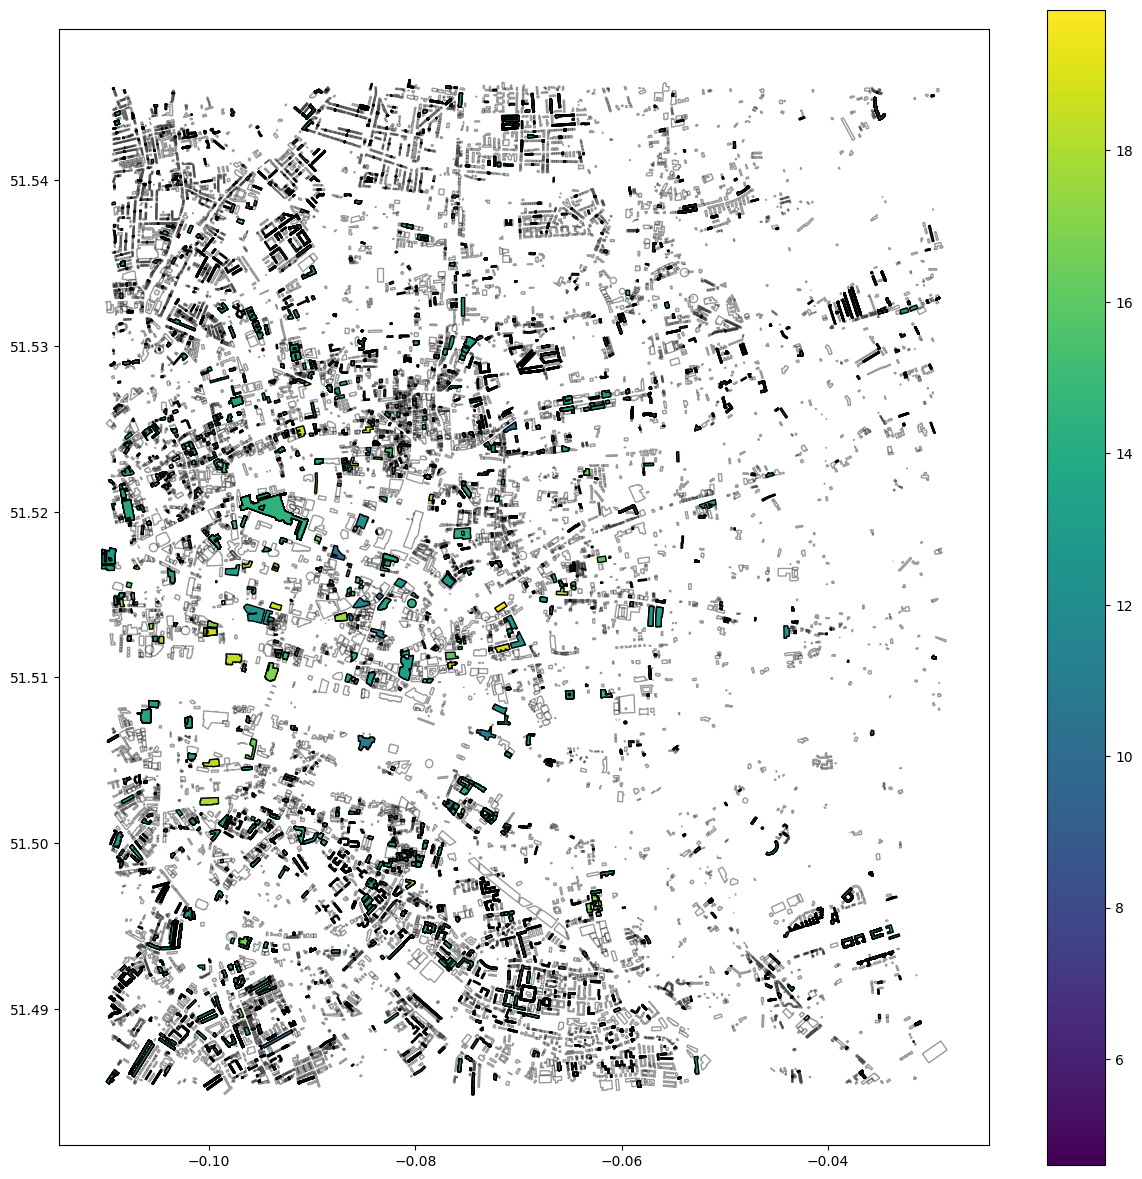

In [150]:
# My summer accommodation and its neighbourhood
buildings = get_buildings(
    data=df[df.postcode == 'E1 7QR'].iloc[0],
    box_width=0.08,
    box_height=0.06,
)

fig, ax = plt.subplots(figsize=(15, 15))
base = buildings.plot(ax=ax, color='white', edgecolor='black', alpha=0.4)
buildings.assign(ax=ax, log_price=lambda df: df.price.pipe(np.log)).plot(ax=base, column='log_price', edgecolor='black', legend=True)

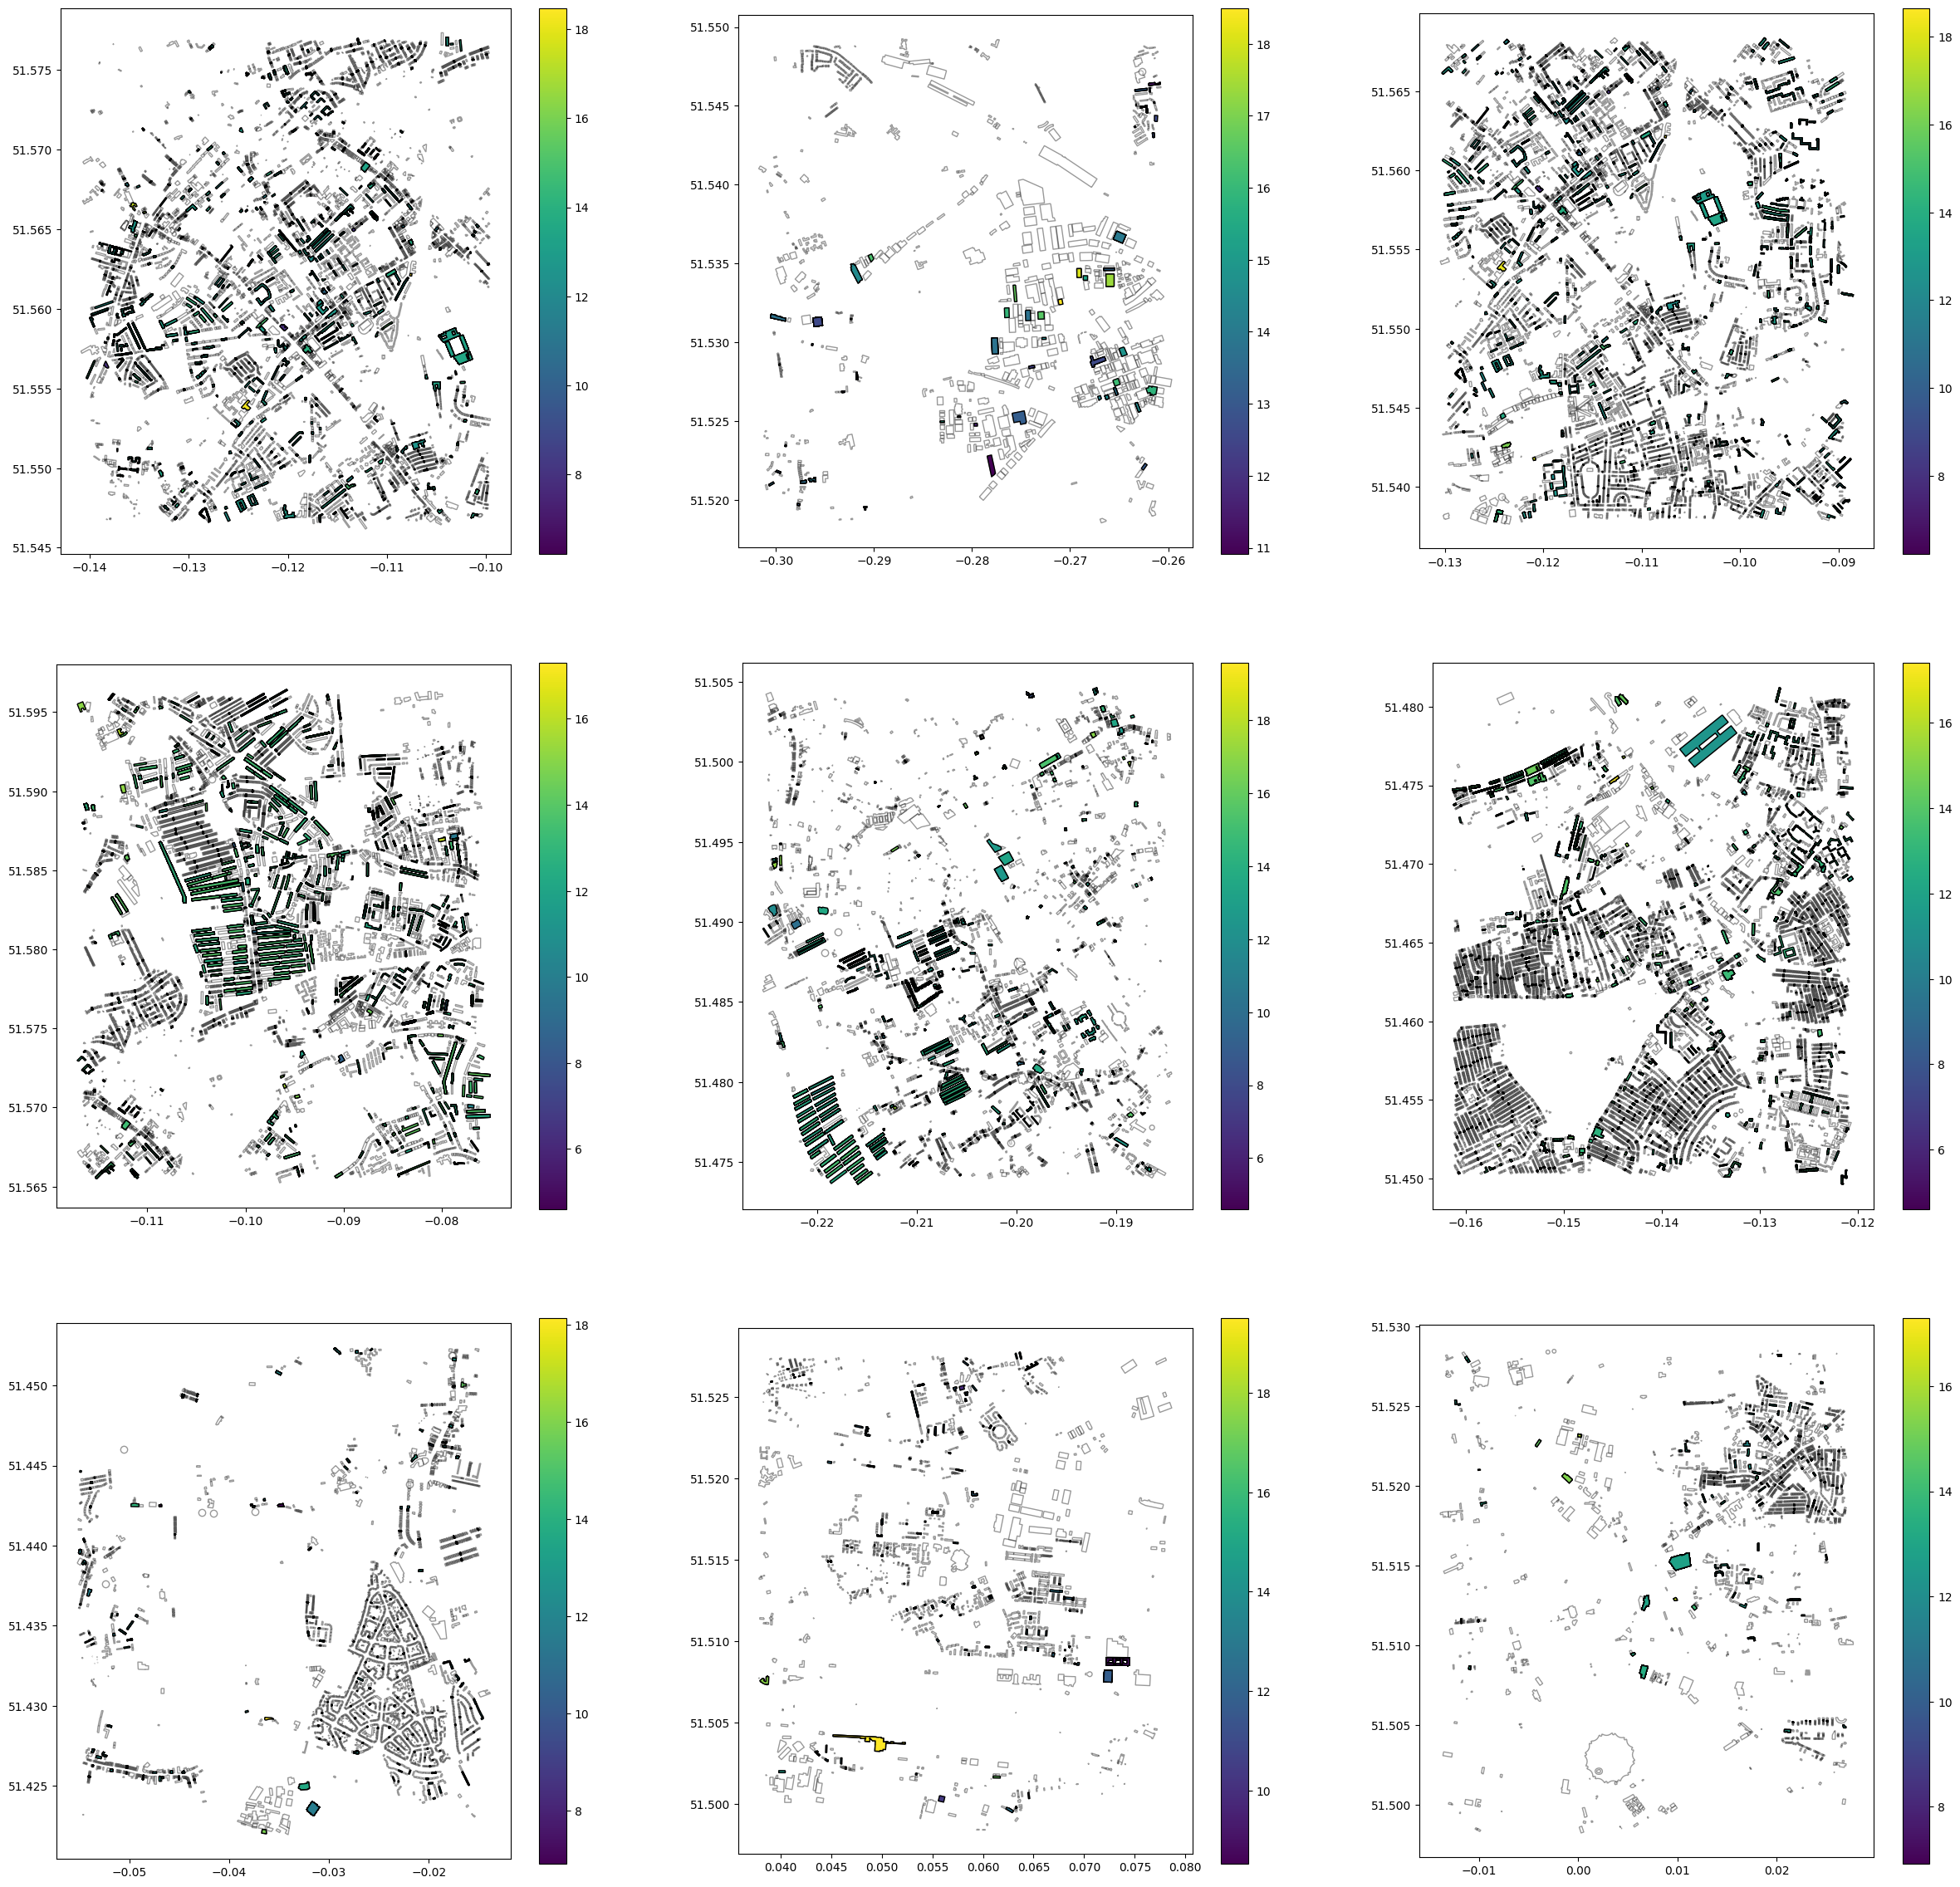

In [155]:
axis = subplots_iter(3, max_subplots=20, subplot_height=10, subplot_width=10)
for idx, data in df.sample(9, random_state=8232).iterrows():
    ax = next(axis)
    
    buildings = get_buildings(
        data=data,
        box_width=0.04,
        box_height=0.03,
    )
    
    base = buildings.plot(ax=ax, color='white', edgecolor='black', alpha=0.4)
    buildings.assign(ax=ax, log_price=lambda df: df.price.pipe(np.log)).plot(ax=base, column='log_price', edgecolor='black', legend=True)

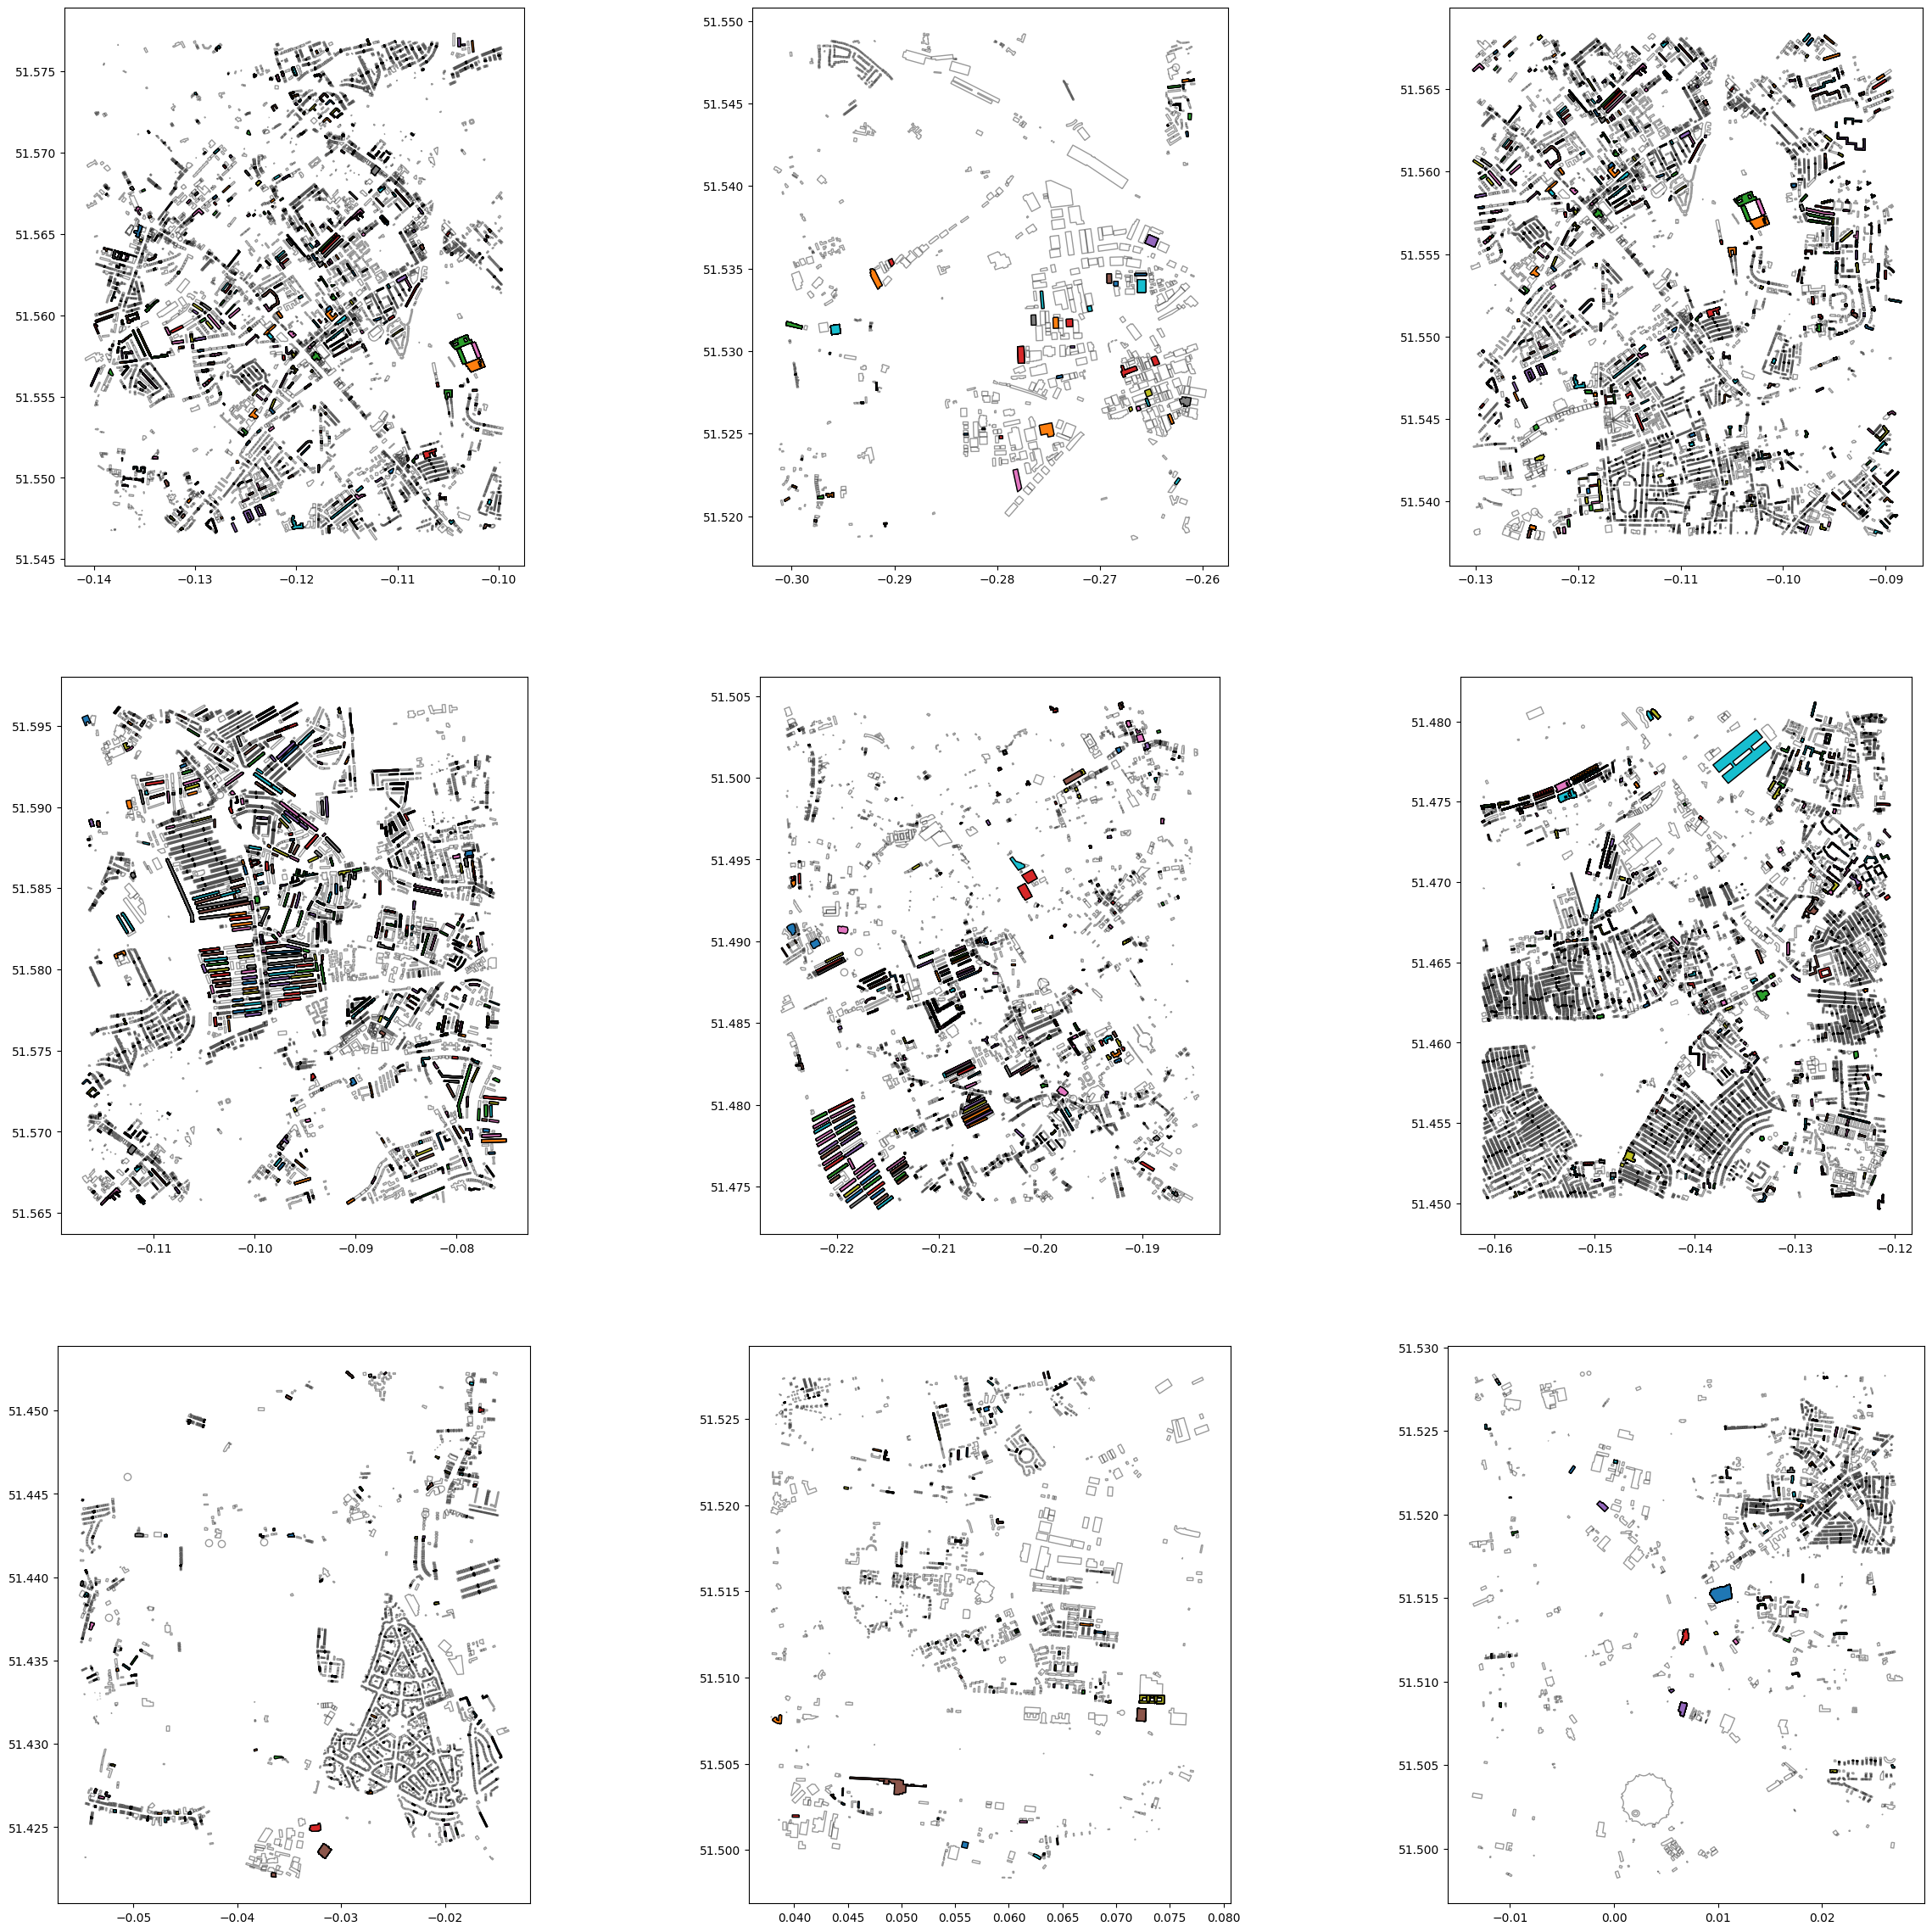

In [159]:
axis = subplots_iter(3, max_subplots=20, subplot_height=10, subplot_width=10)
for idx, data in df.sample(9, random_state=8232).iterrows():
    ax = next(axis)
    
    buildings = get_buildings(
        data=data,
        box_width=0.04,
        box_height=0.03,
    )
    
    base = buildings.plot(ax=ax, color='white', edgecolor='black', alpha=0.4)
    buildings.plot(ax=base, column='date_of_transfer', edgecolor='black', legend=False)

## Question 3. Addressing a Property Price Prediction Question

For your final tick, we will be asking you to make house price predictions for a given location, date and property type in the UK. You will provide a function that takes input a latitude and longitude as well as the `property_type` (either type" of property (either `F` - flat, `S` - semidetached, `D` - detached, `T` - terraced or `O` other). Create this function in the `address.py` file, for example in the form,

```
def predict_price(latitude, longitude, date, property_type):
    """Price prediction for UK housing."""
    pass
```

We suggest that you use the following approach when building your prediction.

1. Select a bounding box around the housing location in latitude and longitude.
2. Select a data range around the prediction date.
3. Use the data ecosystem you have build above to build a training set from the relevant time period and location in the UK. Include appropriate features from OSM to improve the prediction.
4. Train a linear model on the data set you have created.
5. Validate the quality of the model.
6. Provide a prediction of the price from the model, warning appropriately if your validation indicates the quality of the model is poor.

Please note that the quality of predictions is not the main focus of the assignment - we expect to see models that output reasonable predictions and have positive R^2's, but you should not spend too much time on increasing the model's accuracy.

The knowledge you need to do a first pass through this question will have been taught by end of lab session four (7th November 2023). You will likely want to review your answer as part of *refactoring* your code shortly before hand in.



## Large Language Models

If you used LLMs to generate or fix code in this assignment (recommended), briefly summarise the process and prompts you used. What do you think of the integration of LLMs in the data science pipeline?

```GIVE YOUR WRITTEN ANSWER HERE```

For the database access pipeline I didn't use LLMs, as ChatGPT was down due to [DDoS attacks](https://timesofindia.indiatimes.com/gadgets-news/hackers-trying-to-break-into-chatgpt-servers-heres-what-the-microsoft-backed-company-said/articleshow/105086613.cms)

### FAQs

- Why is my connection to the AWS server intermittent?

If you are using Google Colab, online notebooks may throttle your code or time you out. Local Python code is recommended for tasks for large data management in the database.

- Why do SQL queries take a long time?

Some queries legitimately take a long time, even when done right. We suggest indexing your tables to speed up queries over your database. You can index tables by different columns depending on the queries you want to perform. For example, indexing the tables by `postcode` could speed up the join in Task D. More information regarding indexing in MariaDB is available [here](https://mariadb.com/kb/en/getting-started-with-indexes/).

You may also want to consider creating single or multi-column indices on coordinates, or any other properties you use to select data, if that step is taking a long time.

If your new queries seem stuck, try running `SHOW FULL PROCESSLIST`, and `KILL` any stuck processes.

- Why are table populating processes taking so long?

Again populating the database can take long. However, be careful if you are indexing the tables. You should populate data before indexing. Insert operations are impacted by indexes as they are updated with each new row inserted into the table.

- Some other questions are answered in [this reddit forum](https://www.reddit.com/r/CST_ADS/) or [this doc](https://docs.google.com/document/d/1GfDROyUW8HVs2eyxmJzKrYGRdVyUiVXzPcDfwOO8wX0/edit?usp=sharing). Feel free to also ask about anything that comes up.